In [1]:
#!/usr/bin/python
#import wradlib as wrl
import pylab as pl
from glob import glob
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

import csv
import os
import datetime
import pandas as pd

#shapefile: GIS vector data format (ESRI)
import shapefile as shp  # Requires the pyshp package
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker
import netCDF4 as nc4
from datetime import date,timedelta
import plotly.graph_objs as go
import matplotlib.lines as mlines
import seaborn as sns
import shapely

import importlib
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs  # Projections list

import time
import _pickle as pickle

#import external functions (need pip install ipynb)
import ipynb.fs.full.HaileventsFunctions as HF

# OT filter extension to period 2016-2018, Apr-Oct

Extend process defined in ```3-OT-reanFilter_test1.ipynb``` to the whole period

## - Preliminar setup

In [2]:
#Preliminar parameters:

#Folder address containing data:
fold = '/home/ciccuz/phd/KIT/hail_data/'

#lat/lon coords to cover the whole SPHERA domain:
lonmin_S=6; lonmax_S=19; latmin_S=35; latmax_S=49
latplot_S=[latmin_S,latmax_S]; lonplot_S=[lonmin_S,lonmax_S]
#maps limits whole SPHERA domain
xlim=lonplot_S
ylim=latplot_S

#Shapefiles with geopandas: NEW VERSION!
sfg_ita = gpd.read_file(fold + "hail4_punge/geodata/ITA_adm/ITA_adm0.shp", encoding='latin-1')
sfg_deu = gpd.read_file(fold + "hail4_punge/geodata/DEU_adm/DEU_adm0.shp", encoding='latin-1')
sfg_aut = gpd.read_file(fold + "hail4_punge/geodata/AUT_adm/AUT_adm0.shp", encoding='latin-1')
sfg_che = gpd.read_file(fold + "hail4_punge/geodata/CHE_adm/CHE_adm0.shp", encoding='latin-1')
sfg_cro = gpd.read_file(fold + "hail4_punge/geodata/Croatia/mj788hg8036.shp", encoding='latin-1')
sfg_slo = gpd.read_file(fold + "hail4_punge/geodata/Slovenia/gk259nt7452.shp", encoding='latin-1')
sfg_hun = gpd.read_file(fold + "hail4_punge/geodata/Hungary/qh513vs8921.shp", encoding='latin-1')
sfg_alg = gpd.read_file(fold + "hail4_punge/geodata/algeria/rt767cn2098.shp", encoding='latin-1')
sfg_tun = gpd.read_file(fold + "hail4_punge/geodata/tunisia/TUN_adm0.shp", encoding='latin-1')
sfg_bos = gpd.read_file(fold + "hail4_punge/geodata/bosnia/bt512fj0408.shp", encoding='latin-1')
sfg_fra = gpd.read_file(fold + "hail4_punge/geodata/france/dw125xh0996.shp", encoding='latin-1')
sfg_mon = gpd.read_file(fold + "hail4_punge/geodata/montenegro/MNE_adm0.shp", encoding='latin-1')
sfg_cze = gpd.read_file(fold + "hail4_punge/geodata/czech/CZE_adm0.shp", encoding='latin-1')
sfg_svk = gpd.read_file(fold + "hail4_punge/geodata/slovakia/SVK_adm0.shp", encoding='latin-1')

#shapefile in vector form for considering multiple geographic shapefiles
sf_geo = [sfg_ita, sfg_aut, sfg_deu, sfg_che, sfg_cro, sfg_slo, sfg_hun, sfg_alg, sfg_tun, sfg_fra, sfg_bos,
          sfg_mon, sfg_cze, sfg_svk]

#store cities for plotting in maps
clonsel, clatsel, csizesel, cnamesel, ckindsel = HF.HF_cities(latmin_S,latmax_S,lonmin_S,lonmax_S)

#read shapefile of SPHERA 10km grid:
sf_sp = gpd.read_file(fold + "data/lampinet/mask/grid_10_49N.shp", encoding='latin-1')

hhmin=0
hhmax=23

In [3]:
#SETUP THRESHOLDS FOR SPHERA PROXIES (percentiles of param distributions in presence of ESWD report)

#SET WHEN CONSIDERING TEMP WINDOW = 3H,2-98 perc thresholds
#t_CAPE = 505.32
#t_K = 30.2
#t_LI = -1.27
#t_DLS = 7.4
#t_H0 = 4104.5

#SET WHEN CONSIDERING TEMP WINDOW = 3H,5-95 perc thresholds
t_CAPE = 618.42
t_K = 32.5
t_LI = -2.08
t_DLS = 9.25
t_H0 = 4039

In [4]:
#LIST OF DAYS WITH JULIAN DAY AND DATETIME FORMAT:

#days in 2016: 214 days (actually 211 because the following days are missing: 2016185,2016186,2016201 )
days_2016 = [2016092,2016093,2016094,2016095,2016096,2016097,2016098,2016099,2016100,2016101,2016102,2016103,2016104,
        2016105,2016106,2016107,2016108,2016109,2016110,2016111,2016112,2016113,2016114,2016115,2016116,2016117,
        2016118,2016119,2016120,2016121,2016122,2016123,2016124,2016125,2016126,2016127,2016128,2016129,2016130,
        2016131,2016132,2016133,2016134,2016135,2016136,2016137,2016138,2016139,2016140,2016141,2016142,2016143,
        2016144,2016145,2016146,2016147,2016148,2016149,2016150,2016151,2016152,2016153,2016154,2016155,2016156,
        2016157,2016158,2016159,2016160,2016161,2016162,2016163,2016164,2016165,2016166,2016167,2016168,2016169,
        2016170,2016171,2016172,2016173,2016174,2016175,2016176,2016177,2016178,2016179,2016180,2016181,2016182,
        2016183,2016184,2016185,2016186,2016187,2016188,2016189,2016190,2016191,2016192,2016193,2016194,2016195,
        2016196,2016197,2016198,2016199,2016200,2016201,2016202,2016203,2016204,2016205,2016206,2016207,2016208,
        2016209,2016210,2016211,2016212,2016213,2016214,2016215,2016216,2016217,2016218,2016219,2016220,2016221,
        2016222,2016223,2016224,2016225,2016226,2016227,2016228,2016229,2016230,2016231,2016232,2016233,2016234,
        2016235,2016236,2016237,2016238,2016239,2016240,2016241,2016242,2016243,2016244,2016245,2016246,2016247,
        2016248,2016249,2016250,2016251,2016252,2016253,2016254,2016255,2016256,2016257,2016258,2016259,2016260,
        2016261,2016262,2016263,2016264,2016265,2016266,2016267,2016268,2016269,2016270,2016271,2016272,2016273,
        2016274,2016275,2016276,2016277,2016278,2016279,2016280,2016281,2016282,2016283,2016284,2016285,2016286,
        2016287,2016288,2016289,2016290,2016291,2016292,2016293,2016294,2016295,2016296,2016297,2016298,2016299,
        2016300,2016301,2016302,2016303,2016304,2016305]

#days in 2017: missing 1 april (2017091), 213 days
days_2017 = [2017091,2017092,2017093,2017094,2017095,2017096,2017097,2017098,2017099,2017100,2017101,2017102,2017103,2017104,
        2017105,2017106,2017107,2017108,2017109,2017110,2017111,2017112,2017113,2017114,2017115,2017116,2017117,
        2017118,2017119,2017120,2017121,2017122,2017123,2017124,2017125,2017126,2017127,2017128,2017129,2017130,
        2017131,2017132,2017133,2017134,2017135,2017136,2017137,2017138,2017139,2017140,2017141,2017142,2017143,
        2017144,2017145,2017146,2017147,2017148,2017149,2017150,2017151,2017152,2017153,2017154,2017155,2017156,
        2017157,2017158,2017159,2017160,2017161,2017162,2017163,2017164,2017165,2017166,2017167,2017168,2017169,
        2017170,2017171,2017172,2017173,2017174,2017175,2017176,2017177,2017178,2017179,2017180,2017181,2017182,
        2017183,2017184,2017185,2017186,2017187,2017188,2017189,2017190,2017191,2017192,2017193,2017194,2017195,
        2017196,2017197,2017198,2017199,2017200,2017201,2017202,2017203,2017204,2017205,2017206,2017207,2017208,
        2017209,2017210,2017211,2017212,2017213,2017214,2017215,2017216,2017217,2017218,2017219,2017220,2017221,
        2017222,2017223,2017224,2017225,2017226,2017227,2017228,2017229,2017230,2017231,2017232,2017233,2017234,
        2017235,2017236,2017237,2017238,2017239,2017240,2017241,2017242,2017243,2017244,2017245,2017246,2017247,
        2017248,2017249,2017250,2017251,2017252,2017253,2017254,2017255,2017256,2017257,2017258,2017259,2017260,
        2017261,2017262,2017263,2017264,2017265,2017266,2017267,2017268,2017269,2017270,2017271,2017272,2017273,
        2017274,2017275,2017276,2017277,2017278,2017279,2017280,2017281,2017282,2017283,2017284,2017285,2017286,
        2017287,2017288,2017289,2017290,2017291,2017292,2017293,2017294,2017295,2017296,2017297,2017298,2017299,
        2017300,2017301,2017302,2017303,2017304]

#days in 2018: missing 1 april (2018091) and 17 june (2018168), 212 days
days_2018 = [2018091,2018092,2018093,2018094,2018095,2018096,2018097,2018098,2018099,2018100,2018101,2018102,2018103,2018104,
        2018105,2018106,2018107,2018108,2018109,2018110,2018111,2018112,2018113,2018114,2018115,2018116,2018117,
        2018118,2018119,2018120,2018121,2018122,2018123,2018124,2018125,2018126,2018127,2018128,2018129,2018130,
        2018131,2018132,2018133,2018134,2018135,2018136,2018137,2018138,2018139,2018140,2018141,2018142,2018143,
        2018144,2018145,2018146,2018147,2018148,2018149,2018150,2018151,2018152,2018153,2018154,2018155,2018156,
        2018157,2018158,2018159,2018160,2018161,2018162,2018163,2018164,2018165,2018166,2018167,2018168,2018169,
        2018170,2018171,2018172,2018173,2018174,2018175,2018176,2018177,2018178,2018179,2018180,2018181,2018182,
        2018183,2018184,2018185,2018186,2018187,2018188,2018189,2018190,2018191,2018192,2018193,2018194,2018195,
        2018196,2018197,2018198,2018199,2018200,2018201,2018202,2018203,2018204,2018205,2018206,2018207,2018208,
        2018209,2018210,2018211,2018212,2018213,2018214,2018215,2018216,2018217,2018218,2018219,2018220,2018221,
        2018222,2018223,2018224,2018225,2018226,2018227,2018228,2018229,2018230,2018231,2018232,2018233,2018234,
        2018235,2018236,2018237,2018238,2018239,2018240,2018241,2018242,2018243,2018244,2018245,2018246,2018247,
        2018248,2018249,2018250,2018251,2018252,2018253,2018254,2018255,2018256,2018257,2018258,2018259,2018260,
        2018261,2018262,2018263,2018264,2018265,2018266,2018267,2018268,2018269,2018270,2018271,2018272,2018273,
        2018274,2018275,2018276,2018277,2018278,2018279,2018280,2018281,2018282,2018283,2018284,2018285,2018286,
        2018287,2018288,2018289,2018290,2018291,2018292,2018293,2018294,2018295,2018296,2018297,2018298,2018299,
        2018300,2018301,2018302,2018303,2018304]

#write dataframes storing julian days and datetimes of OT days:

days_2016_df =pd.DataFrame(index=np.arange(0,len(days_2016),1), columns=['day','dtime'])
days_2017_df =pd.DataFrame(index=np.arange(0,len(days_2017),1), columns=['day','dtime'])
days_2018_df =pd.DataFrame(index=np.arange(0,len(days_2018),1), columns=['day','dtime'])

for day,ind in zip(days_2016,np.arange(0,len(days_2016),1)):
    
    dtime = datetime.datetime.strptime('2016-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2016_df.iloc[ind]['day'] = day
    days_2016_df.iloc[ind]['dtime'] = dtime    

for day,ind in zip(days_2017,np.arange(0,len(days_2017),1)):
    
    dtime = datetime.datetime.strptime('2017-04-02','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2017_df.iloc[ind]['day'] = day
    days_2017_df.iloc[ind]['dtime'] = dtime    
    
for day,ind in zip(days_2018,np.arange(0,len(days_2018),1)):
    
    dtime = datetime.datetime.strptime('2018-04-02','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2018_df.iloc[ind]['day'] = day
    days_2018_df.iloc[ind]['dtime'] = dtime    

#REMEMBER FOR 2018 MISSING DAY: 2018168 at index 76 (17 jun)

In [5]:
#write dataframes storing julian days and datetimes of OT days:

days_2016_df =pd.DataFrame(index=np.arange(0,len(days_2016),1), columns=['day','dtime'])
days_2017_df =pd.DataFrame(index=np.arange(0,len(days_2017),1), columns=['day','dtime'])
days_2018_df =pd.DataFrame(index=np.arange(0,len(days_2018),1), columns=['day','dtime'])

for day,ind in zip(days_2016,np.arange(0,len(days_2016),1)):
    
    dtime = datetime.datetime.strptime('2016-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2016_df.iloc[ind]['day'] = day
    days_2016_df.iloc[ind]['dtime'] = dtime    

for day,ind in zip(days_2017,np.arange(0,len(days_2017),1)):
    
    dtime = datetime.datetime.strptime('2017-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2017_df.iloc[ind]['day'] = day
    days_2017_df.iloc[ind]['dtime'] = dtime    
    
for day,ind in zip(days_2018,np.arange(0,len(days_2018),1)):
    
    dtime = datetime.datetime.strptime('2018-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2018_df.iloc[ind]['day'] = day
    days_2018_df.iloc[ind]['dtime'] = dtime    

days_2016_df.dtime = pd.to_datetime(days_2016_df.dtime)
days_2017_df.dtime = pd.to_datetime(days_2017_df.dtime)
days_2018_df.dtime = pd.to_datetime(days_2018_df.dtime)

#REMOVE MISSING DAYS (after creating dataframes otherwise day and dtime are shifted and wrong!!!)

#-2016: 2016185,2016186,2016201
days_2016_df = days_2016_df[(days_2016_df.day !=2016185) & (days_2016_df.day !=2016186) & 
                            (days_2016_df.day !=2016201)]
#-2017: 2017091 
days_2017_df = days_2017_df[days_2017_df.day != 2017091]

#-2018: 2018091, 2018168
days_2018_df = days_2018_df[(days_2018_df.day != 2018091) & (days_2018_df.day != 2018168)]

<span style="color:red"> REMEMBER: for SPHERA the first hour of the first day of april (00) is missing, and also for the first 2 days to extract the "day before" is not possible, must adapt script at the beginning of temporal domain of each year 

</span>

MISSING DAYS (DUE TO SPHERA DATA MISSING, OR OT DATA MISSING):
- 2016092 SPHERA data devono esere trattati separatamente e mancano OTs fino alle 0600
- 2016093 SPHERA data devono essere trattati separatamente
- (41) 2016133 OT mancanti fino alle 2115
- 109 2016201 2016-07-19 -> SPHERA data mancanti dalle 11 alle 23 (SKIP DAY)
- (198) 2016290 (MET09 invece di MET10)
- (199) 2016291 OT data mancanti fino alle 1300


- (18) 2017110 (MET08 invece di MET10)
- (19) 2017111 OT data mancanti fino alle 1545
- (147) 2017239 (MET08 invece di MET10)


- (35) 2018127 (MET09 ainvece di MET11)
- (36) 2018128 OT data mancanti fino alle 0900
-	2018168 (17-6-2018): missing OT data whole day (but no eswd reports and 6 unipol reports)
- (100) 2018192 OT mancanti fino alle 0815
- (128) 2018220 OT mancanti fino alle 0015


MISSING DAYS (DUE TO SPHERA DATA MISSING, OR OT DATA MISSING):

- ·	2016185 (3-7-2016): missing SPHERA data whole day (but only 32 OTs detected whole day, and no ESWD reports detected)
- ·	2016186 (4-7-2016): missing SPHERA data only 00UTC (but no OTs detected whole day, and no ESWD reports detected)

In [6]:
hhmin=0

d_ind = 88
day = days_2017_df['day'][d_ind]
dtime = days_2017_df['dtime'][d_ind]

dtime,day

(Timestamp('2017-06-28 00:00:00'), 2017179)

In [7]:
days_2017_df

,day,dtime
1,2017092,2017-04-02
2,2017093,2017-04-03
3,2017094,2017-04-04
4,2017095,2017-04-05
5,2017096,2017-04-06
...,...,...
209,2017300,2017-10-27
210,2017301,2017-10-28
211,2017302,2017-10-29
212,2017303,2017-10-30


In [27]:
othstart = '0600'
otdir=fold + f'data/OT_SEVIRI_data_2016-2018/{dtime.year}/{day}/';
otpref='NASALARC_MET10_SEVIRI_OTDETECTION_'

In [46]:
cpclat, cpclon, otpmax, dtmin, ot_timing = HF.HF_OTdata(day,hhmin,hhmin+23,otpref,otdir,othstart)
gdf_OT = HF.HF_OTdata_2_gdf(cpclat,cpclon,otpmax,ot_timing)
gdf_OT

lon        lat                  time  otpmax  \
xlon xlat                                                       
83   228   14.088715  45.876858  2016-04-01T06:00:00Z    0.65   
84   228   14.088715  45.841145  2016-04-01T06:00:00Z    0.65   
192  171   12.072000  42.004002  2016-04-01T06:00:00Z    0.62   
193  167   11.929143  41.968288  2016-04-01T06:00:00Z    0.62   
     169   12.000571  41.967285  2016-04-01T06:00:00Z    0.62   
     170   12.036285  41.967285  2016-04-01T06:00:00Z    0.62   
     171   12.071000  41.968288  2016-04-01T06:00:00Z    0.62   
     173   12.141429  41.966286  2016-04-01T06:00:00Z    0.60   
     174   12.177143  41.965286  2016-04-01T06:00:00Z    0.60   
     175   12.212857  41.966286  2016-04-01T06:00:00Z    0.60   
     176   12.249572  41.967285  2016-04-01T06:00:00Z    0.60   
194  159   11.645429  41.933571  2016-04-01T06:00:00Z    0.74   
     160   11.680142  41.930569  2016-04-01T06:00:00Z    0.74   
     161   11.715857  41.931568  2016-04-01T06:00:00Z    0.74   
     169   12.000571  41.932571  2016-04-01T06:00:00Z    0.62   
     170   12.036285  41.932571  2016-04-01T06:00:00Z    0.62   
     171   12.072000  41.932571  2016-04-01T06:00:00Z    0.62   
     173   12.141429  41.930569  2016-04-01T06:00:00Z    0.60   
     174   12.177143  41.930569  2016-04-01T06:00:00Z    0.60   
     175   12.213858  41.931568  2016-04-01T06:00:00Z    0.60   
     176   12.248571  41.931568  2016-04-01T06:00:00Z    0.60   
195  166   11.894428  41.897858  2016-04-01T06:00:00Z    0.61   
196  167   11.929143  41.861145  2016-04-01T06:00:00Z    0.61   
     168   11.964857  41.861145  2016-04-01T06:00:00Z    0.61   
259  50     7.771572  39.621143  2016-04-01T06:00:00Z    0.60   
     51     7.807286  39.621143  2016-04-01T06:00:00Z    0.60   
260  50     7.771572  39.585426  2016-04-01T06:00:00Z    0.60   
     65     8.304286  39.584427  2016-04-01T06:00:00Z    0.60   
     66     8.340000  39.584427  2016-04-01T06:00:00Z    0.60   
261  64     8.268571  39.547714  2016-04-01T06:00:00Z    0.60   
     65     8.305285  39.548714  2016-04-01T06:00:00Z    0.60   
263  47     7.665429  39.479286  2016-04-01T06:00:00Z    0.60   
265  69     8.447144  39.405857  2016-04-01T06:00:00Z    0.51   
     70     8.482858  39.405857  2016-04-01T06:00:00Z    0.51   
     71     8.518572  39.404858  2016-04-01T06:00:00Z    0.51   
     72     8.553286  39.404858  2016-04-01T06:00:00Z    0.51   
266  49     7.735857  39.372143  2016-04-01T06:00:00Z    0.52   
     69     8.447144  39.371143  2016-04-01T06:00:00Z    0.51   
     70     8.482858  39.370144  2016-04-01T06:00:00Z    0.51   
     71     8.517571  39.369144  2016-04-01T06:00:00Z    0.51   
     72     8.554286  39.370144  2016-04-01T06:00:00Z    0.51   
272  64     8.269570  39.158855  2016-04-01T06:00:00Z    0.54   
289  58     8.057286  38.553719  2016-04-01T06:00:00Z    0.77   
347  263   15.349713  36.484287  2016-04-01T06:00:00Z    0.65   

                            geometry  
xlon xlat                             
83   228   POINT (14.08871 45.87686)  
84   228   POINT (14.08871 45.84114)  
192  171   POINT (12.07200 42.00400)  
193  167   POINT (11.92914 41.96829)  
     169   POINT (12.00057 41.96729)  
     170   POINT (12.03629 41.96729)  
     171   POINT (12.07100 41.96829)  
     173   POINT (12.14143 41.96629)  
     174   POINT (12.17714 41.96529)  
     175   POINT (12.21286 41.96629)  
     176   POINT (12.24957 41.96729)  
194  159   POINT (11.64543 41.93357)  
     160   POINT (11.68014 41.93057)  
     161   POINT (11.71586 41.93157)  
     169   POINT (12.00057 41.93257)  
     170   POINT (12.03629 41.93257)  
     171   POINT (12.07200 41.93257)  
     173   POINT (12.14143 41.93057)  
     174   POINT (12.17714 41.93057)  
     175   POINT (12.21386 41.93157)  
     176   POINT (12.24857 41.93157)  
195  166   POINT (11.89443 41.89786)  
196  167   POINT (11.92914 41.86115)  
     168   POINT (11.96486 41.86115)  
259  50     

In [21]:
df_sp = HF.HF_reanProxies_read(dtime)
df_sp

,datetime,box_id,%VV700,AvvGeop500,Kindex,LI,DLS,H0,CAPE_MU,CAPE_ML
0,2017-04-02 00:00:00,0,40.000000,180.716476,-9.070973,8.914912,38.792347,2408.64380,0.000000,0.000000
1,2017-04-02 00:00:00,1,78.260872,-1753.157840,-3.257645,7.122036,40.950489,2343.89136,0.519022,0.013587
2,2017-04-02 00:00:00,2,22.727272,481.346100,4.525341,6.728964,41.160408,2193.38062,1.102273,0.301136
3,2017-04-02 00:00:00,3,0.000000,2301.237060,0.357579,7.481563,35.941338,2314.09375,0.000000,0.000000
4,2017-04-02 00:00:00,4,45.000000,-196.218719,-5.342917,7.352534,35.219276,2430.67505,0.000000,0.010937
...,...,...,...,...,...,...,...,...,...,...
435595,2017-04-02 23:00:00,18145,33.333332,0.000000,24.038717,2.211414,6.573776,2505.12500,41.666668,17.354166
435596,2017-04-02 23:00:00,18146,25.000000,0.000000,24.294800,2.097034,6.683518,2518.90625,42.484375,16.523438
435597,2017-04-02 23:00:00,18147,33.333332,0.000000,24.383749,1.855131,6.941826,2561.00000,40.666668,14.916667
435598,2017-04-02 23:00:00,18148,33.333332,0.000000,24.516968,1.668282,7.147036,2599.20825,43.677082,13.406250


### - Single days (when some problems with SPHERA/OT data)

In [ ]:
dtime = dtime-timedelta(days=1)

In [22]:
dtime

Timestamp('2017-04-02 00:00:00')

In [23]:
sp_res = 10  #10km res grid, kept constant

df_sp = pd.DataFrame(columns=["Data","Macroarea","%VV700","AvvGeop500","Kindex","LI","DeepShear",
                              "H0","CAPE_MU","CAPE_ML"])

#read hourly dataframes and aggregate them to form a daily dataframe
for i in np.arange(1,24,1):

    df_temp_SLI_K_AvvGeop_VV700 = pd.read_csv(fold + f'data/SPHERA/sphera_indices_grid{sp_res}km/SLI_K_AvvGeop_VV700/{dtime.year}/ind_'+
                          f'{dtime.year}'+"{:02d}".format(dtime.month)+"{:02d}".format(dtime.day)+"{:02d}".format(i)+'00.csv', 
                          sep=',').drop(columns=["Unnamed: 6"])
    df_temp_CAPE_H0_DLS = pd.read_csv(fold + f'data/SPHERA/sphera_indices_grid{sp_res}km/CAPE_H0_DLS/{dtime.year}/ind_'+
                          f'{dtime.year}'+"{:02d}".format(dtime.month)+"{:02d}".format(dtime.day)+"{:02d}".format(i)+'00_CAPE_H0_DLS.csv', 
                          sep=',').drop(columns=["Unnamed: 6"])

    df_temp = pd.concat([df_temp_SLI_K_AvvGeop_VV700, df_temp_CAPE_H0_DLS[['DeepShear','H0','CAPE_MU','CAPE_ML']]],
                        axis=1, join="inner")
    df_sp = df_sp.append(df_temp, ignore_index=True)


In [24]:


df_sp = df_sp.rename(columns={'Data' : 'datetime', 'Macroarea' : 'box_id', 'DeepShear' : 'DLS'})

df_sp['datetime'] = pd.to_datetime(df_sp['datetime'], format='%Y%m%d%H')

#drop all rows where one (and so all) of the parameters has huge values >1e38
df_sp = df_sp.drop(df_sp.loc[df_sp.LI > 1e38].index)

#FIX BOX_ID INDEX: make it start from 0 and not 1 otherwise all grid cells are shifted to the left of 1!
df_sp.box_id = df_sp.box_id - 1

In [25]:
df_sp_Dbefore = df_sp
df_sp_Dbefore

,datetime,box_id,%VV700,AvvGeop500,Kindex,LI,DLS,H0,CAPE_MU,CAPE_ML
0,2017-04-02 01:00:00,0,40.000000,330.346924,-8.791501,9.712077,38.383160,2381.76880,0.000000,0.000000
1,2017-04-02 01:00:00,1,73.913040,-1412.878050,-4.993440,9.201640,40.410118,2286.73901,0.679348,0.184783
2,2017-04-02 01:00:00,2,27.272728,377.309967,-0.652693,8.661998,39.920479,2072.86353,0.588068,0.134943
3,2017-04-02 01:00:00,3,0.000000,2259.312990,-3.751535,9.169597,34.433510,2191.90625,0.000000,0.000000
4,2017-04-02 01:00:00,4,35.000000,378.132751,-8.967153,9.146355,32.699635,2392.44385,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
417445,2017-04-02 23:00:00,18145,33.333332,0.000000,24.038717,2.211414,6.573776,2505.12500,41.666668,17.354166
417446,2017-04-02 23:00:00,18146,25.000000,0.000000,24.294800,2.097034,6.683518,2518.90625,42.484375,16.523438
417447,2017-04-02 23:00:00,18147,33.333332,0.000000,24.383749,1.855131,6.941826,2561.00000,40.666668,14.916667
417448,2017-04-02 23:00:00,18148,33.333332,0.000000,24.516968,1.668282,7.147036,2599.20825,43.677082,13.406250


In [28]:
#dictionary to contain hourly geodataframes of unfiltered and filtered OTs:
dORIG_gdf_OT_daily = dict()
dFILT_gdf_OT_daily = dict()

#for loop for filtering OTs based on SPHERA rean parameters:
"""
FINAL SET OF FILTER CONSIDERED FOR EXTENSION:
-temporal window: 0-3h
-spatial window: 70km
-thresholds: 5-95%
"""

print(d_ind, day, dtime)

for hh in np.arange(hhmin,hhmax+1,1):
    print(f'hour = {hh}')
    #read original OT data:
    cpclat, cpclon, otpmax, dtmin, ot_timing = HF.HF_OTdata(day,hh,hh+1,otpref,otdir,othstart)
    print('step1 - read OTs')

    #condition: if there aren't OTs detected in the current hour (i.e. len(ot_timing=0)) skip to next hour:
    if len(ot_timing) == 0:
        continue

    #convert to geodataframes
    gdf_OT = HF.HF_OTdata_2_gdf(cpclat,cpclon,otpmax,ot_timing)

    if len(gdf_OT) == 0:
        continue

    dORIG_gdf_OT_daily[gdf_OT['time'].iloc[0]] = gdf_OT
    print('step2 - convert to gdf')

    #condition to exit loop if there are no OTs detected in the last hour:
    if len(gdf_OT) == 0:
        dFILT_gdf_OT_daily[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
        continue
    else:

        #extract SPHERA data aggregated over the last 3 hours before including hhmin
        gdf_sp_3OTh = HF.HF_rean_tAgg_OTh(gdf_OT, df_sp, df_sp_Dbefore, sf_sp)
        print('step3 - temporal aggregation of SPHERA data')

        #extract the spatial windows around every SPHERA cell containing at least 1 OT detection
        dgdf_sp_3OTh_nn = HF.HF_rean_spatWindowOT(gdf_OT, gdf_sp_3OTh)
        print('step4 - spatial neighbourhood of SPHERA data')

        #filter OT data:
        FILT_gdf_OT = HF.HF_OTfilter(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0)
        dFILT_gdf_OT_daily[gdf_OT['time'].iloc[0]] = FILT_gdf_OT  #assign time to dataset nested in dictionary

#write dictionaries of geodataframes containing for each hour of the day the original and filtered OTs datasets,
#plus a dataframe of metadata containing the info for each our of filtered OTs and daily amount of:
filt_nonfilt_OTs = dict()

filt_nonfilt_OTs['ORIGINAL_OTs'] = dORIG_gdf_OT_daily
filt_nonfilt_OTs['FILTERED_OTs'] = dFILT_gdf_OT_daily
filt_nonfilt_OTs['metadata'] = pd.DataFrame(index=np.arange(0,24,1),columns=['hour','Filt_OTs','Orig_OTs'])

for ind,hour in zip(np.arange(0,24,1),dFILT_gdf_OT_daily.keys()):

    filt_nonfilt_OTs['metadata'].loc[ind]['hour'] = hour
    filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs'] = len(dFILT_gdf_OT_daily[hour])
    filt_nonfilt_OTs['metadata'].loc[ind]['Orig_OTs'] = len(dORIG_gdf_OT_daily[hour])

#write dictionary of filtered/unfiltered OTs to external file
print('WRITE EXTERNAL FILE')
with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_2ROUND/2017/OTfilt_{day}.txt', 'wb') as file:
     pickle.dump(filt_nonfilt_OTs,file)

1 2017092 2017-04-02 00:00:00
hour = 0
step1 - read OTs
step2 - convert to gdf
step3 - temporal aggregation of SPHERA data
step4 - spatial neighbourhood of SPHERA data
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
hour = 1
step1 - read OTs
step2 - convert to gdf
step3 - temporal aggregation of SPHERA data
step4 - spatial neighbourhood of SPHERA data
Filtered 3 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 9 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 8 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
Filt

### - Loop on several days

In [8]:
days_2017_df.index[88]

89

In [10]:
#Loop on days:
for d_ind in [88]:#days_2017_df.index[148:]:
    
    start_time = time.time()

    day = days_2017_df['day'][d_ind]
    dtime = days_2017_df['dtime'][d_ind]

    #OT params:
    if dtime.year == 2018:
        otpref='NASALARC_MET11_SEVIRI_OTDETECTION_'     #2018

    else:
        otpref='NASALARC_MET10_SEVIRI_OTDETECTION_'     #2016 2017

    otdir=fold + f'data/OT_SEVIRI_data_2016-2018/{dtime.year}/{day}/';
    othstart = '0000'
    
    #read daily sphera data
    df_sp = HF.HF_reanProxies_read(dtime)
    df_sp_Dbefore = HF.HF_reanProxies_read(dtime-timedelta(days=1)) 

    #dictionary to contain hourly geodataframes of unfiltered and filtered OTs:
    dORIG_gdf_OT_daily = dict()
    dFILT_gdf_OT_daily = dict()

    #for loop for filtering OTs based on SPHERA rean parameters:
    """
    FINAL SET OF FILTER CONSIDERED FOR EXTENSION:
    -temporal window: 0-3h
    -spatial window: 70km
    -thresholds: 5-95%
    """

    print(d_ind, day, dtime, f'Time: {time.time() - start_time}')

    for hh in np.arange(hhmin,hhmax+1,1):
        print(f'hour = {hh}')
        #read original OT data:
        cpclat, cpclon, otpmax, dtmin, ot_timing = HF.HF_OTdata(day,hh,hh+1,otpref,otdir,othstart)
        print(f'step1 - read OTs. Time: {time.time() - start_time}')

        #condition: if there aren't OTs detected in the current hour (i.e. len(ot_timing=0)) skip to next hour:
        if len(ot_timing) == 0:
            continue

        #convert to geodataframes
        gdf_OT = HF.HF_OTdata_2_gdf(cpclat,cpclon,otpmax,ot_timing)

        if len(gdf_OT) == 0:
            continue

        dORIG_gdf_OT_daily[gdf_OT['time'].iloc[0]] = gdf_OT
        print(f'step2 - convert to gdf. Time: {time.time() - start_time}')

        #condition to exit loop if there are no OTs detected in the last hour:
        if len(gdf_OT) == 0:
            dFILT_gdf_OT_daily[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
            continue
        else:

            #extract SPHERA data aggregated over the last 3 hours before including hhmin
            gdf_sp_3OTh = HF.HF_rean_tAgg_OTh(gdf_OT, df_sp, df_sp_Dbefore, sf_sp)
            print(f'step3 - temporal aggregation of SPHERA data. Time: {time.time() - start_time}')

            #extract the spatial windows around every SPHERA cell containing at least 1 OT detection
            dgdf_sp_3OTh_nn = HF.HF_rean_spatWindowOT(gdf_OT, gdf_sp_3OTh)
            print(f'step4 - spatial neighbourhood of SPHERA data. Time: {time.time() - start_time}')

            #filter OT data:
            FILT_gdf_OT = HF.HF_OTfilter(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0)
            dFILT_gdf_OT_daily[gdf_OT['time'].iloc[0]] = FILT_gdf_OT  #assign time to dataset nested in dictionary

    #write dictionaries of geodataframes containing for each hour of the day the original and filtered OTs datasets,
    #plus a dataframe of metadata containing the info for each our of filtered OTs and daily amount of:
    filt_nonfilt_OTs = dict()

    filt_nonfilt_OTs['ORIGINAL_OTs'] = dORIG_gdf_OT_daily
    filt_nonfilt_OTs['FILTERED_OTs'] = dFILT_gdf_OT_daily
    filt_nonfilt_OTs['metadata'] = pd.DataFrame(index=np.arange(0,24,1),columns=['hour','Filt_OTs','Orig_OTs'])

    for ind,hour in zip(np.arange(0,24,1),dFILT_gdf_OT_daily.keys()):

        filt_nonfilt_OTs['metadata'].loc[ind]['hour'] = hour
        filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs'] = len(dFILT_gdf_OT_daily[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['Orig_OTs'] = len(dORIG_gdf_OT_daily[hour])

    #write dictionary of filtered/unfiltered OTs to external file
    print('WRITE EXTERNAL FILE')
    #with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_2ROUND/2017/OTfilt_{day}.txt', 'wb') as file:
    #     pickle.dump(filt_nonfilt_OTs,file)

88 2017179 2017-06-28 00:00:00 Time: 3.3798112869262695
hour = 0
step1 - read OTs. Time: 3.548008441925049
step2 - convert to gdf. Time: 8.543045043945312
step3 - temporal aggregation of SPHERA data. Time: 8.883824825286865
step4 - spatial neighbourhood of SPHERA data. Time: 112.7096734046936
Filtered 5 OTs
Filtered 8 OTs
Filtered 8 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 7 OTs
Filtered 4 OTs
1 OTs kept!
Filtered 1 OTs
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 3 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtere

step1 - read OTs. Time: 658.0857870578766
step2 - convert to gdf. Time: 662.1695551872253
step3 - temporal aggregation of SPHERA data. Time: 662.4079051017761
step4 - spatial neighbourhood of SPHERA data. Time: 755.0603382587433
Filtered 2 OTs
5 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
Filtered 5 OTs
Filtered 3 OTs
2 OTs kept!
1 OTs kept!
Filtered 3 OTs
Filtered 1 OTs
2 OTs kept!
3 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!


1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
Filtered 1 OTs
5 OTs kept!
2 OTs kept!
2 OTs kept!
Filtered 6 OTs
5 OTs kept!
2 OTs kept!
Filtered 3 OTs
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
Filtered 1 OTs
hour = 13
step1 - read OTs. Time: 1449.9945006370544
step2 - convert to gdf. Time: 1453.4530284404755
step3 - temporal aggregation of SPHERA data. Time: 1453.670509815216
step4 - spatial neighbourhood of SPHERA data. Time: 1734.7986319065094
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
8 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 

5 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
8 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
7 OTs kept!
9 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
9 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
9 OTs kept!
8 OTs kept!
4 OTs kept!
9 OTs kept!
7 OTs kept!
2 OTs kept!
6 OT

Filtered 9 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 8 OTs
Filtered 3 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 1 OTs
4 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
Filtered 7 OTs
Filtered 6 OTs
Filtered 5 OTs
Filtered 2 OTs
4 OTs kept!
Filtered 4 OTs
2 OTs kept!
Filtered 1 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
2 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
hour = 20
step1 - read OTs. Time: 2941.162595272064
step2 - convert to gdf. Time: 2944.4208691120148
step3 - temporal aggregation of 

In [11]:
filt_nonfilt_OTs_FULL_FILT = filt_nonfilt_OTs

In [12]:
filt_nonfilt_OTs_FULL_FILT['metadata']

,hour,Filt_OTs,Orig_OTs
0,2017-06-28T00:00:00Z,49,193
1,2017-06-28T01:00:00Z,85,166
2,2017-06-28T02:00:00Z,124,224
3,2017-06-28T03:00:00Z,78,173
4,2017-06-28T04:00:00Z,68,126
5,2017-06-28T05:00:00Z,120,191
6,2017-06-28T06:00:00Z,113,121
7,2017-06-28T07:00:00Z,72,80
8,2017-06-28T08:00:00Z,34,57
9,2017-06-28T09:00:00Z,163,199


In [7]:
#read dictionary from external file
with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_2ROUND/2017/OTfilt_{day}.txt', "rb") as file:  
     OTFILTERED = pickle.load(file)

In [13]:
sum(OTFILTERED['metadata']['Filt_OTs_Kindex'][:17])

1320

In [14]:
sum(OTFILTERED['metadata']['Filt_OTs_LI'][:17])

1325

In [15]:
sum(OTFILTERED['metadata']['Filt_OTs_DLS'][:17])

1577

In [18]:
sum(OTFILTERED['metadata']['Orig_OTs'][:17])

1678

In [8]:
OTFILTERED['metadata']

,hour,Filt_OTs,Orig_OTs
0,2017-06-24T00:00:00Z,46,49
1,2017-06-24T01:00:00Z,6,21
2,2017-06-24T07:00:00Z,0,1
3,2017-06-24T10:00:00Z,0,10
4,2017-06-24T11:00:00Z,0,2
5,2017-06-24T12:00:00Z,4,29
6,2017-06-24T13:00:00Z,0,102
7,2017-06-24T14:00:00Z,5,179
8,2017-06-24T15:00:00Z,2,90
9,2017-06-24T16:00:00Z,49,121


In [9]:
sum(OTFILTERED['metadata']['Orig_OTs'][:17])

1678

In [10]:
sum(OTFILTERED['metadata']['Filt_OTs'][:17])

418

In [64]:
OTFILTERED['metadata']

,hour,Filt_OTs,Orig_OTs
0,2017-06-24T00:00:00Z,49,49
1,2017-06-24T01:00:00Z,21,21
2,2017-06-24T07:00:00Z,1,1
3,2017-06-24T10:00:00Z,10,10
4,2017-06-24T11:00:00Z,2,2
5,2017-06-24T12:00:00Z,29,29
6,2017-06-24T13:00:00Z,102,102
7,2017-06-24T14:00:00Z,179,179
8,2017-06-24T15:00:00Z,90,90
9,2017-06-24T16:00:00Z,121,121


In [65]:
sum(OTFILTERED['metadata']['Orig_OTs'][:17])

1678

In [66]:
sum(OTFILTERED['metadata']['Filt_OTs'][:17])

1672

In [67]:
orig_OT = OTFILTERED['ORIGINAL_OTs']
filt_OT = OTFILTERED['FILTERED_OTs']

In [68]:
df_eswd = pd.read_csv(fold + 'hail4_punge/ESWD/ESWD_HAIL_19790101-20200531_v1_6.csv')

lonmin=6; lonmax=19; latmin=35; latmax=49

#selection over the whole SPHERA domain
eswd_ev_sel = HF.HF_eswd_df(df_eswd,dtime.year,dtime.month,dtime.day,hhmin,hhmax,latmin,latmax,lonmin,lonmax)

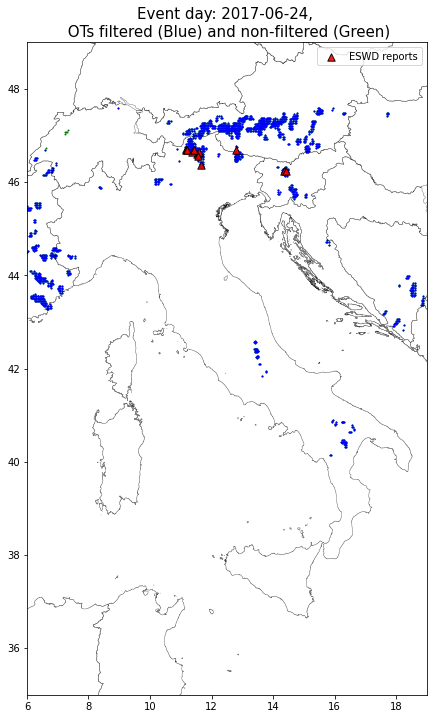

In [70]:
fig, ax = plt.subplots(figsize = (20,12))
latplot=[latmin,latmax]; lonplot=[lonmin,lonmax]
x_lim=lonplot
y_lim=latplot
plt.xlim(x_lim)
plt.ylim(y_lim) #y_lim

#filtered and non-filtered OTs detections    
for hour in orig_OT.keys():
    orig_OT[hour][['otpmax','geometry']].plot(ax=ax, markersize=1, figsize=(12, 8), column='otpmax', 
                                              color='green', zorder=1)
    if len(filt_OT[hour]) != 0:
        filt_OT[hour][['otpmax','geometry']].plot(ax=ax, markersize=1, figsize=(12, 8), column='otpmax', 
                                                  color='blue', zorder=2)
#shapefiles    
for shp in sf_geo:
    shp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)

#eswd 
if len(eswd_ev_sel) != 0:
    pl.scatter(eswd_ev_sel.lon,eswd_ev_sel.lat,55,c='red',marker="^",edgecolor='k',alpha=0.9,zorder=4, 
           label='ESWD reports')

plt.legend(loc='best')

plt.title(f'Event day: {dtime.year}-{dtime.month:02d}-{dtime.day:02d}, \n OTs filtered (Blue) and non-filtered (Green)',
         fontsize=15);

## - Modification to consider multiple singular filtering for separate parameters:

##### - Single days when problems with SPHERA

In [26]:
hhmin=0

d_ind = 1
day = days_2016_df['day'][d_ind]
dtime = days_2016_df['dtime'][d_ind]

dtime,day

(Timestamp('2016-04-02 00:00:00'), 2016093)

In [27]:
othstart = '0000'
otdir=fold + f'data/OT_SEVIRI_data_2016-2018/{dtime.year}/{day}/';
otpref='NASALARC_MET10_SEVIRI_OTDETECTION_'

In [28]:
sp_res = 10  #10km res grid, kept constant

df_sp = pd.DataFrame(columns=["Data","Macroarea","%VV700","AvvGeop500","Kindex","LI","DeepShear",
                              "H0","CAPE_MU","CAPE_ML"])

#read hourly dataframes and aggregate them to form a daily dataframe
for i in np.arange(1,24,1):

    df_temp_SLI_K_AvvGeop_VV700 = pd.read_csv(fold + f'data/SPHERA/sphera_indices_grid{sp_res}km/SLI_K_AvvGeop_VV700/{dtime.year}/ind_'+
                          f'{dtime.year}'+"{:02d}".format(dtime.month)+"{:02d}".format(dtime.day)+"{:02d}".format(i)+'00.csv', 
                          sep=',').drop(columns=["Unnamed: 6"])
    df_temp_CAPE_H0_DLS = pd.read_csv(fold + f'data/SPHERA/sphera_indices_grid{sp_res}km/CAPE_H0_DLS/{dtime.year}/ind_'+
                          f'{dtime.year}'+"{:02d}".format(dtime.month)+"{:02d}".format(dtime.day)+"{:02d}".format(i)+'00_CAPE_H0_DLS.csv', 
                          sep=',').drop(columns=["Unnamed: 6"])

    df_temp = pd.concat([df_temp_SLI_K_AvvGeop_VV700, df_temp_CAPE_H0_DLS[['DeepShear','H0','CAPE_MU','CAPE_ML']]],
                        axis=1, join="inner")
    df_sp = df_sp.append(df_temp, ignore_index=True)
    
df_sp = df_sp.rename(columns={'Data' : 'datetime', 'Macroarea' : 'box_id', 'DeepShear' : 'DLS'})

df_sp['datetime'] = pd.to_datetime(df_sp['datetime'], format='%Y%m%d%H')

#drop all rows where one (and so all) of the parameters has huge values >1e38
df_sp = df_sp.drop(df_sp.loc[df_sp.LI > 1e38].index)

#FIX BOX_ID INDEX: make it start from 0 and not 1 otherwise all grid cells are shifted to the left of 1!
df_sp.box_id = df_sp.box_id - 1

In [29]:
df_sp_Dbefore = df_sp

In [30]:
#dictionary to contain hourly geodataframes of unfiltered and filtered OTs:
dORIG_gdf_OT_daily = dict()
dFILT_gdf_OT_daily_Kindex = dict()
dFILT_gdf_OT_daily_LI = dict()
dFILT_gdf_OT_daily_DLS = dict()
dFILT_gdf_OT_daily_H0 = dict()
dFILT_gdf_OT_daily_CAPE = dict()

#for loop for filtering OTs based on SPHERA rean parameters:
"""
FINAL SET OF FILTER CONSIDERED FOR EXTENSION:
-temporal window: 0-3h
-spatial window: 70km
-thresholds: 5-95%
"""

print(d_ind, day, dtime, f'Time: {time.time() - start_time}')

for hh in np.arange(hhmin,hhmax+1,1):
    print(f'hour = {hh}')
    #read original OT data:
    cpclat, cpclon, otpmax, dtmin, ot_timing = HF.HF_OTdata(day,hh,hh+1,otpref,otdir,othstart)
    print(f'step1 - read OTs. Time: {time.time() - start_time}')

    #condition: if there aren't OTs detected in the current hour (i.e. len(ot_timing=0)) skip to next hour:
    if len(ot_timing) == 0:
        continue

    #convert to geodataframes
    gdf_OT = HF.HF_OTdata_2_gdf(cpclat,cpclon,otpmax,ot_timing)

    if len(gdf_OT) == 0:
        continue

    dORIG_gdf_OT_daily[gdf_OT['time'].iloc[0]] = gdf_OT
    print(f'step2 - convert to gdf. Time: {time.time() - start_time}')

    #condition to exit loop if there are no OTs detected in the last hour:
    if len(gdf_OT) == 0:
        dFILT_gdf_OT_daily_Kindex[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
        dFILT_gdf_OT_daily_LI[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
        dFILT_gdf_OT_daily_DLS[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
        dFILT_gdf_OT_daily_H0[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
        dFILT_gdf_OT_daily_CAPE[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()

        continue
    else:

        #extract SPHERA data aggregated over the last 3 hours before including hhmin
        gdf_sp_3OTh = HF.HF_rean_tAgg_OTh(gdf_OT, df_sp, df_sp_Dbefore, sf_sp)
        print(f'step3 - temporal aggregation of SPHERA data. Time: {time.time() - start_time}')

        #extract the spatial windows around every SPHERA cell containing at least 1 OT detection
        dgdf_sp_3OTh_nn = HF.HF_rean_spatWindowOT(gdf_OT, gdf_sp_3OTh)
        print(f'step4 - spatial neighbourhood of SPHERA data. Time: {time.time() - start_time}')

        #filter OT data separately for different parameters:
        FILT_gdf_OT_Kindex = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                    param='Kindex')
        FILT_gdf_OT_LI = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                    param='LI')
        FILT_gdf_OT_DLS = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                    param='DLS')
        FILT_gdf_OT_H0 = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                    param='H0')
        FILT_gdf_OT_CAPE = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                        param='CAPE_MU')
        
        dFILT_gdf_OT_daily_Kindex[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_Kindex  #assign time to dataset nested in dictionary
        dFILT_gdf_OT_daily_LI[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_LI  #assign time to dataset nested in dictionary
        dFILT_gdf_OT_daily_DLS[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_DLS  #assign time to dataset nested in dictionary
        dFILT_gdf_OT_daily_H0[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_H0  #assign time to dataset nested in dictionary
        dFILT_gdf_OT_daily_CAPE[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_CAPE  #assign time to dataset nested in dictionary

#write dictionaries of geodataframes containing for each hour of the day the original and filtered OTs datasets,
#plus a dataframe of metadata containing the info for each our of filtered OTs and daily amount of:
filt_nonfilt_OTs = dict()

filt_nonfilt_OTs['ORIGINAL_OTs'] = dORIG_gdf_OT_daily
filt_nonfilt_OTs['FILTERED_OTs_Kindex'] = dFILT_gdf_OT_daily_Kindex
filt_nonfilt_OTs['FILTERED_OTs_LI'] = dFILT_gdf_OT_daily_LI
filt_nonfilt_OTs['FILTERED_OTs_DLS'] = dFILT_gdf_OT_daily_DLS
filt_nonfilt_OTs['FILTERED_OTs_H0'] = dFILT_gdf_OT_daily_H0
filt_nonfilt_OTs['FILTERED_OTs_CAPE'] = dFILT_gdf_OT_daily_CAPE
filt_nonfilt_OTs['metadata'] = pd.DataFrame(index=np.arange(0,24,1),columns=['hour','Filt_OTs_Kindex',
                                                                             'Filt_OTs_LI','Filt_OTs_DLS',
                                                                             'Filt_OTs_H0','Filt_OTs_CAPE',
                                                                             'Orig_OTs'])

for ind,hour in zip(np.arange(0,24,1),dFILT_gdf_OT_daily_Kindex.keys()):

    filt_nonfilt_OTs['metadata'].loc[ind]['hour'] = hour
    filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_Kindex'] = len(dFILT_gdf_OT_daily_Kindex[hour])
    filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_LI'] = len(dFILT_gdf_OT_daily_LI[hour])
    filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_DLS'] = len(dFILT_gdf_OT_daily_DLS[hour])
    filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_H0'] = len(dFILT_gdf_OT_daily_H0[hour])
    filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_CAPE'] = len(dFILT_gdf_OT_daily_CAPE[hour])
    filt_nonfilt_OTs['metadata'].loc[ind]['Orig_OTs'] = len(dORIG_gdf_OT_daily[hour])

#write dictionary of filtered/unfiltered OTs to external file
print('WRITE EXTERNAL FILE')
with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_singleParams_NEW/2016/OTfilt_{day}.txt', 'wb') as file:
     pickle.dump(filt_nonfilt_OTs,file)

1 2016093 2016-04-02 00:00:00 Time: 660.9219539165497
hour = 0
step1 - read OTs. Time: 661.2792439460754
step2 - convert to gdf. Time: 664.2164607048035
step3 - temporal aggregation of SPHERA data. Time: 664.4025602340698
step4 - spatial neighbourhood of SPHERA data. Time: 672.0969839096069
Only K filter!
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Only LI filter!
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Only DLS filter!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only H0 filter!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
ho

Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Only LI filter!
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 7 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 

Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 2

1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
Filtered 1 OTs
Filtered 2 OTs
5 OTs kept!
Filtered 2 OTs
2 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
3 OTs kept!
5 OTs kept!
3 OTs kept!
Filtered 4 OTs
1 OTs kept!
Filtered 1 OTs
3 OTs kept!
6 OTs kept!
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
5 OTs kept!
Filtered 1 OTs
1 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
5 OTs kept!
Filtered 2 OTs
Filtered 3 OTs
2 OTs kept!
3 OTs kept!
Filtered 1 OTs
2 OTs kept!
Filtered 1 OTs
4 OTs kept!
2 OTs k

Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 8 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1

2 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
F

5 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 2 OTs
2 OTs kept!
2 OTs kept!
Filtered 1 OTs
2 OTs kept!
Filtered 2 OTs
2 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 1 OTs
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
Filtered 1 OTs
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs k

step1 - read OTs. Time: 1579.110271692276
step2 - convert to gdf. Time: 1582.4992916584015
step3 - temporal aggregation of SPHERA data. Time: 1582.7087745666504
step4 - spatial neighbourhood of SPHERA data. Time: 1583.7366693019867
Only K filter!
Filtered 1 OTs
Only LI filter!
Filtered 1 OTs
Only DLS filter!
1 OTs kept!
Only H0 filter!
1 OTs kept!
Only CAPE_MU filter!
Filtered 1 OTs
hour = 9
step1 - read OTs. Time: 1584.2782652378082
hour = 10
step1 - read OTs. Time: 1588.2039847373962
hour = 11
step1 - read OTs. Time: 1592.0147740840912
hour = 12
step1 - read OTs. Time: 1595.740313053131
hour = 13
step1 - read OTs. Time: 1599.5707936286926
hour = 14
step1 - read OTs. Time: 1603.374580860138
hour = 15
step1 - read OTs. Time: 1607.2294626235962
hour = 16
step1 - read OTs. Time: 1611.0208892822266
hour = 17
step1 - read OTs. Time: 1614.8058595657349
hour = 18
step1 - read OTs. Time: 1618.6582996845245
hour = 19
step1 - read OTs. Time: 1622.3969445228577
hour = 20
step1 - read OTs. Time: 

In [11]:
#Loop on days:
for d_ind in [112]:#days_2016_df.index[110:]:
    start_time = time.time()

    day = days_2016_df['day'][d_ind]
    dtime = days_2016_df['dtime'][d_ind]

    #OT params:
    if dtime.year == 2018:
        otpref='NASALARC_MET11_SEVIRI_OTDETECTION_'     #2018

    else:
        otpref='NASALARC_MET10_SEVIRI_OTDETECTION_'     #2016 2017

    otdir=fold + f'data/OT_SEVIRI_data_2016-2018/{dtime.year}/{day}/';
    othstart = '0000'
    
    #read daily sphera data
    df_sp = HF.HF_reanProxies_read(dtime)
    df_sp_Dbefore = HF.HF_reanProxies_read(dtime-timedelta(days=1)) 

    #dictionary to contain hourly geodataframes of unfiltered and filtered OTs:
    dORIG_gdf_OT_daily = dict()
    
    dFILT_gdf_OT_daily_Kindex = dict()
    dFILT_gdf_OT_daily_LI = dict()
    dFILT_gdf_OT_daily_DLS = dict()
    dFILT_gdf_OT_daily_H0 = dict()
    dFILT_gdf_OT_daily_CAPE = dict()

    #for loop for filtering OTs based on SPHERA rean parameters:
    """
    FINAL SET OF FILTER CONSIDERED FOR EXTENSION:
    -temporal window: 0-3h
    -spatial window: 70km
    -thresholds: 5-95%
    """

    print(d_ind, day, dtime, f'Time: {time.time() - start_time}')

    for hh in np.arange(hhmin,hhmax+1,1):
        print(f'hour = {hh}')
        #read original OT data:
        cpclat, cpclon, otpmax, dtmin, ot_timing = HF.HF_OTdata(day,hh,hh+1,otpref,otdir,othstart)
        print(f'step1 - read OTs. Time: {time.time() - start_time}')

        #condition: if there aren't OTs detected in the current hour (i.e. len(ot_timing=0)) skip to next hour:
        if len(ot_timing) == 0:
            continue

        #convert to geodataframes
        gdf_OT = HF.HF_OTdata_2_gdf(cpclat,cpclon,otpmax,ot_timing)

        if len(gdf_OT) == 0:
            continue

        dORIG_gdf_OT_daily[gdf_OT['time'].iloc[0]] = gdf_OT
        print(f'step2 - convert to gdf. Time: {time.time() - start_time}')

        #condition to exit loop if there are no OTs detected in the last hour:
        if len(gdf_OT) == 0:
            dFILT_gdf_OT_daily_Kindex[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
            dFILT_gdf_OT_daily_LI[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
            dFILT_gdf_OT_daily_DLS[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
            dFILT_gdf_OT_daily_H0[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
            dFILT_gdf_OT_daily_CAPE[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()


            continue
        else:

            #extract SPHERA data aggregated over the last 3 hours before including hhmin
            gdf_sp_3OTh = HF.HF_rean_tAgg_OTh(gdf_OT, df_sp, df_sp_Dbefore, sf_sp)
            print(f'step3 - temporal aggregation of SPHERA data. Time: {time.time() - start_time}')

            #extract the spatial windows around every SPHERA cell containing at least 1 OT detection
            dgdf_sp_3OTh_nn = HF.HF_rean_spatWindowOT(gdf_OT, gdf_sp_3OTh)
            print(f'step4 - spatial neighbourhood of SPHERA data. Time: {time.time() - start_time}')

            #filter OT data separately for different parameters:
            FILT_gdf_OT_Kindex = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                        param='Kindex')
            FILT_gdf_OT_LI = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                        param='LI')
            FILT_gdf_OT_DLS = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                        param='DLS')
            FILT_gdf_OT_H0 = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                        param='H0')
            FILT_gdf_OT_CAPE = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                        param='CAPE_MU')
            
            dFILT_gdf_OT_daily_Kindex[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_Kindex  #assign time to dataset nested in dictionary
            dFILT_gdf_OT_daily_LI[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_LI  #assign time to dataset nested in dictionary
            dFILT_gdf_OT_daily_DLS[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_DLS  #assign time to dataset nested in dictionary
            dFILT_gdf_OT_daily_H0[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_H0  #assign time to dataset nested in dictionary
            dFILT_gdf_OT_daily_CAPE[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_CAPE  #assign time to dataset nested in dictionary

    #write dictionaries of geodataframes containing for each hour of the day the original and filtered OTs datasets,
    #plus a dataframe of metadata containing the info for each our of filtered OTs and daily amount of:
    filt_nonfilt_OTs = dict()

    filt_nonfilt_OTs['ORIGINAL_OTs'] = dORIG_gdf_OT_daily
    filt_nonfilt_OTs['FILTERED_OTs_Kindex'] = dFILT_gdf_OT_daily_Kindex
    filt_nonfilt_OTs['FILTERED_OTs_LI'] = dFILT_gdf_OT_daily_LI
    filt_nonfilt_OTs['FILTERED_OTs_DLS'] = dFILT_gdf_OT_daily_DLS
    filt_nonfilt_OTs['FILTERED_OTs_H0'] = dFILT_gdf_OT_daily_H0
    filt_nonfilt_OTs['FILTERED_OTs_CAPE'] = dFILT_gdf_OT_daily_CAPE
    filt_nonfilt_OTs['metadata'] = pd.DataFrame(index=np.arange(0,24,1),columns=['hour','Filt_OTs_Kindex',
                                                                                 'Filt_OTs_LI','Filt_OTs_DLS',
                                                                                 'Filt_OTs_H0','Filt_OTs_CAPE',
                                                                                 'Orig_OTs'])

    for ind,hour in zip(np.arange(0,24,1),dFILT_gdf_OT_daily_Kindex.keys()):

        filt_nonfilt_OTs['metadata'].loc[ind]['hour'] = hour
        filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_Kindex'] = len(dFILT_gdf_OT_daily_Kindex[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_LI'] = len(dFILT_gdf_OT_daily_LI[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_DLS'] = len(dFILT_gdf_OT_daily_DLS[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_H0'] = len(dFILT_gdf_OT_daily_H0[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_CAPE'] = len(dFILT_gdf_OT_daily_CAPE[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['Orig_OTs'] = len(dORIG_gdf_OT_daily[hour])

    #write dictionary of filtered/unfiltered OTs to external file
    print('WRITE EXTERNAL FILE')
    with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_singleParams_NEW/2016/OTfilt_{day}.txt', 'wb') as file:
         pickle.dump(filt_nonfilt_OTs,file)

112 2016204 2016-07-22 00:00:00 Time: 5.327620029449463
hour = 0
step1 - read OTs. Time: 5.724029779434204
step2 - convert to gdf. Time: 8.917246580123901
step3 - temporal aggregation of SPHERA data. Time: 9.144413948059082
step4 - spatial neighbourhood of SPHERA data. Time: 26.096659898757935
Only K filter!
9 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
9 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
Only DLS filter!
9 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
Only H0 filter!
9 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs

step4 - spatial neighbourhood of SPHERA data. Time: 174.5468726158142
Only K filter!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
Only LI filter!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
Only DLS filter!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
Only H0 filter!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
Only CAPE_MU filter!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs

step4 - spatial neighbourhood of SPHERA data. Time: 349.081666469574
Only K filter!
3 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
6 OTs kept!
8 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
3 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
6 OTs kept!
8 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only DLS filter!
3 OTs kept!
2 OTs k

6 OTs kept!
9 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
8 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
Only DLS filter!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!

step1 - read OTs. Time: 639.5420014858246
step2 - convert to gdf. Time: 642.9286661148071
step3 - temporal aggregation of SPHERA data. Time: 643.1506876945496
step4 - spatial neighbourhood of SPHERA data. Time: 683.3291900157928
Only K filter!
1 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
8 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
Only LI filter!
1 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
8 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs ke

5 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
Only H0 filter!
3 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
3 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
hour = 21
step1 - read OTs. Time: 846.3671977519989
step2 - convert to gdf. Time: 850.6070175170898
step3 - temporal aggregation of SPHERA data. Time: 850.8871688842773
step4 - spatial neighbourhood of SPHERA data. Time: 872.6608095169067
Only K filter!
2 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
2

In [ ]:
filt_nonfilt_OTs_SINGLE_FILT = filt_nonfilt_OTs

In [17]:
filt_nonfilt_OTs_SINGLE_FILT['metadata']

,hour,Filt_OTs_Kindex,Filt_OTs_LI,Filt_OTs_DLS,Filt_OTs_H0,Orig_OTs
0,2017-06-28T00:00:00Z,193,152,193,90,193
1,2017-06-28T01:00:00Z,160,166,166,91,166
2,2017-06-28T02:00:00Z,224,224,224,124,224
3,2017-06-28T03:00:00Z,173,170,173,78,173
4,2017-06-28T04:00:00Z,126,126,126,68,126
5,2017-06-28T05:00:00Z,190,191,191,120,191
6,2017-06-28T06:00:00Z,119,121,121,113,121
7,2017-06-28T07:00:00Z,77,80,80,75,80
8,2017-06-28T08:00:00Z,43,57,57,37,57
9,2017-06-28T09:00:00Z,199,185,199,177,199


In [19]:
with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_singleParams_NEW/2017/OTfilt_{day}.txt', 'wb') as file:
         pickle.dump(filt_nonfilt_OTs_SINGLE_FILT,file)

In [15]:
OTFILTERED.keys()

dict_keys(['ORIGINAL_OTs', 'FILTERED_OTs_Kindex', 'FILTERED_OTs_LI', 'FILTERED_OTs_DLS', 'FILTERED_OTs_H0', 'metadata'])

In [16]:
OTFILTERED['ORIGINAL_OTs']

{'2016-04-07T00:00:00Z':                 lon        lat                  time  otpmax  \
 xlon xlat                                                      
 339  76    8.702143  36.784000  2016-04-07T00:00:00Z    0.74   
 340  76    8.702143  36.748283  2016-04-07T00:00:00Z    0.74   
 
                            geometry  
 xlon xlat                            
 339  76    POINT (8.70214 36.78400)  
 340  76    POINT (8.70214 36.74828)  ,
 '2016-04-07T01:00:00Z':                 lon        lat                  time  otpmax  \
 xlon xlat                                                      
 308  82    8.914429  37.886143  2016-04-07T01:00:00Z    0.64   
 309  88    9.127715  37.850426  2016-04-07T01:00:00Z    0.58   
      89    9.163429  37.849426  2016-04-07T01:00:00Z    0.58   
      90    9.199143  37.850426  2016-04-07T01:00:00Z    0.58   
 310  88    9.127715  37.815716  2016-04-07T01:00:00Z    0.58   
 312  92    9.270572  37.743286  2016-04-07T01:00:00Z    0.51   
      93    9

In [17]:
OTFILTERED['FILTERED_OTs_Kindex']

{'2016-04-07T00:00:00Z': Empty GeoDataFrame
 Columns: [lon, lat, time, otpmax, geometry]
 Index: [],
 '2016-04-07T01:00:00Z': Empty GeoDataFrame
 Columns: [lon, lat, time, otpmax, geometry]
 Index: [],
 '2016-04-07T02:00:00Z': Empty GeoDataFrame
 Columns: [lon, lat, time, otpmax, geometry]
 Index: [],
 '2016-04-07T03:00:00Z': Empty GeoDataFrame
 Columns: [lon, lat, time, otpmax, geometry]
 Index: [],
 '2016-04-07T04:00:00Z': Empty GeoDataFrame
 Columns: [lon, lat, time, otpmax, geometry]
 Index: [],
 '2016-04-07T18:00:00Z':                 lon        lat                  time  otpmax  \
 xlon xlat                                                      
 83   69    8.442143  45.887856  2016-04-07T18:00:00Z    0.67   
 84   68    8.406429  45.853142  2016-04-07T18:00:00Z    0.67   
      69    8.442143  45.852142  2016-04-07T18:00:00Z    0.67   
 
                            geometry  
 xlon xlat                            
 83   69    POINT (8.44214 45.88786)  
 84   68    POINT (8.40643 

In [18]:
OTFILTERED['FILTERED_OTs_LI']

{'2016-04-07T00:00:00Z':                 lon        lat                  time  otpmax  \
 xlon xlat                                                      
 339  76    8.702143  36.784000  2016-04-07T00:00:00Z    0.74   
 340  76    8.702143  36.748283  2016-04-07T00:00:00Z    0.74   
 
                            geometry  
 xlon xlat                            
 339  76    POINT (8.70214 36.78400)  
 340  76    POINT (8.70214 36.74828)  ,
 '2016-04-07T01:00:00Z':                 lon        lat                  time  otpmax  \
 xlon xlat                                                      
 309  88    9.127715  37.850426  2016-04-07T01:00:00Z    0.58   
      89    9.163429  37.849426  2016-04-07T01:00:00Z    0.58   
      90    9.199143  37.850426  2016-04-07T01:00:00Z    0.58   
 310  88    9.127715  37.815716  2016-04-07T01:00:00Z    0.58   
 312  92    9.270572  37.743286  2016-04-07T01:00:00Z    0.51   
      93    9.305285  37.742287  2016-04-07T01:00:00Z    0.51   
 313  92    9

In [20]:
OTFILTERED['FILTERED_OTs_H0']

{'2016-04-07T00:00:00Z':                 lon        lat                  time  otpmax  \
 xlon xlat                                                      
 339  76    8.702143  36.784000  2016-04-07T00:00:00Z    0.74   
 340  76    8.702143  36.748283  2016-04-07T00:00:00Z    0.74   
 
                            geometry  
 xlon xlat                            
 339  76    POINT (8.70214 36.78400)  
 340  76    POINT (8.70214 36.74828)  ,
 '2016-04-07T01:00:00Z':                 lon        lat                  time  otpmax  \
 xlon xlat                                                      
 308  82    8.914429  37.886143  2016-04-07T01:00:00Z    0.64   
 309  88    9.127715  37.850426  2016-04-07T01:00:00Z    0.58   
      89    9.163429  37.849426  2016-04-07T01:00:00Z    0.58   
      90    9.199143  37.850426  2016-04-07T01:00:00Z    0.58   
 310  88    9.127715  37.815716  2016-04-07T01:00:00Z    0.58   
 312  92    9.270572  37.743286  2016-04-07T01:00:00Z    0.51   
      93    9

# - Re-extract only OTs data including info on IR brightness temperature 

So extract gdf_OT for each hour, build a dictionary for each day (as output from the filter) so then later we can include temp. information by selecting with indices

In [17]:
#Loop on days:
for d_ind in days_2018_df.index[128:]:

    start_time = time.time()

    day = days_2018_df['day'][d_ind]
    dtime = days_2018_df['dtime'][d_ind]
    print(d_ind, day, dtime, f'Time: {time.time() - start_time}')

    #OT params:
    if dtime.year == 2018:
        otpref='NASALARC_MET11_SEVIRI_OTDETECTION_'     #2018

    else:
        otpref='NASALARC_MET10_SEVIRI_OTDETECTION_'     #2016 2017

    otdir=fold + f'data/OT_SEVIRI_data_2016-2018/{dtime.year}/{day}/';
    othstart = '0000'

    #dictionary to contain hourly geodataframes of unfiltered and filtered OTs:
    dORIG_gdf_OT_daily = dict()

    for hh in np.arange(hhmin,hhmax+1,1):
        print(f'hour = {hh}')
        #read original OT data:
        cpclat, cpclon, otpmax, dtmin, ot_timing, irbmin = HF.HF_OTdata(day,hh,hh+1,otpref,otdir,othstart)
        print(f'step1 - read OTs. Time: {time.time() - start_time}')

        #condition: if there aren't OTs detected in the current hour (i.e. len(ot_timing=0)) skip to next hour:
        if len(ot_timing) == 0:
            continue

        #convert to geodataframes
        gdf_OT = HF.HF_OTdata_2_gdf(cpclat,cpclon,otpmax,ot_timing,dtmin,irbmin)

        if len(gdf_OT) == 0:
            continue

        dORIG_gdf_OT_daily[gdf_OT['time'].iloc[0]] = gdf_OT

    print('WRITE EXTERNAL FILE')
    with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin/2018/OT_{day}.txt', 'wb') as file:
         pickle.dump(dORIG_gdf_OT_daily,file)

130 2018221 2018-08-09 00:00:00 Time: 0.0005242824554443359
hour = 0
step1 - read OTs. Time: 0.6716866493225098
hour = 1
step1 - read OTs. Time: 4.109587907791138
hour = 2
step1 - read OTs. Time: 7.765366554260254
hour = 3
step1 - read OTs. Time: 11.204377174377441
hour = 4
step1 - read OTs. Time: 14.793834209442139
hour = 5
step1 - read OTs. Time: 19.38629961013794
hour = 6
step1 - read OTs. Time: 24.230616092681885
hour = 7
step1 - read OTs. Time: 28.67510437965393
hour = 8
step1 - read OTs. Time: 33.340683698654175
hour = 9
step1 - read OTs. Time: 37.62233591079712
hour = 10
step1 - read OTs. Time: 41.5467643737793
hour = 11
step1 - read OTs. Time: 45.468634366989136
hour = 12
step1 - read OTs. Time: 49.55682373046875
hour = 13
step1 - read OTs. Time: 53.602890491485596
hour = 14
step1 - read OTs. Time: 57.42947244644165
hour = 15
step1 - read OTs. Time: 61.20780658721924
hour = 16
step1 - read OTs. Time: 65.07443046569824
hour = 17
step1 - read OTs. Time: 68.84069800376892
hour = 1

hour = 4
step1 - read OTs. Time: 15.70622181892395
hour = 5
step1 - read OTs. Time: 19.54117488861084
hour = 6
step1 - read OTs. Time: 23.389431953430176
hour = 7
step1 - read OTs. Time: 27.191497325897217
hour = 8
step1 - read OTs. Time: 31.0405375957489
hour = 9
step1 - read OTs. Time: 34.77026653289795
hour = 10
step1 - read OTs. Time: 38.58651423454285
hour = 11
step1 - read OTs. Time: 42.6082329750061
hour = 12
step1 - read OTs. Time: 46.38079810142517
hour = 13
step1 - read OTs. Time: 50.22627401351929
hour = 14
step1 - read OTs. Time: 53.935004234313965
hour = 15
step1 - read OTs. Time: 57.81053352355957
hour = 16
step1 - read OTs. Time: 61.653690338134766
hour = 17
step1 - read OTs. Time: 65.35989952087402
hour = 18
step1 - read OTs. Time: 69.20190715789795
hour = 19
step1 - read OTs. Time: 72.9712598323822
hour = 20
step1 - read OTs. Time: 76.78270506858826
hour = 21
step1 - read OTs. Time: 80.48670625686646
hour = 22
step1 - read OTs. Time: 84.2879273891449
hour = 23
step1 - 

hour = 9
step1 - read OTs. Time: 34.80992817878723
hour = 10
step1 - read OTs. Time: 38.596171855926514
hour = 11
step1 - read OTs. Time: 42.40294170379639
hour = 12
step1 - read OTs. Time: 46.21315383911133
hour = 13
step1 - read OTs. Time: 50.076470375061035
hour = 14
step1 - read OTs. Time: 53.83359384536743
hour = 15
step1 - read OTs. Time: 57.63632249832153
hour = 16
step1 - read OTs. Time: 61.49294471740723
hour = 17
step1 - read OTs. Time: 65.34126138687134
hour = 18
step1 - read OTs. Time: 69.13881301879883
hour = 19
step1 - read OTs. Time: 72.98512315750122
hour = 20
step1 - read OTs. Time: 76.94670033454895
hour = 21
step1 - read OTs. Time: 80.75679802894592
hour = 22
step1 - read OTs. Time: 84.6358425617218
hour = 23
step1 - read OTs. Time: 88.3656997680664
WRITE EXTERNAL FILE
143 2018234 2018-08-22 00:00:00 Time: 0.00010204315185546875
hour = 0
step1 - read OTs. Time: 0.6185686588287354
hour = 1
step1 - read OTs. Time: 4.480342149734497
hour = 2
step1 - read OTs. Time: 8.16

hour = 14
step1 - read OTs. Time: 54.577638387680054
hour = 15
step1 - read OTs. Time: 58.346359729766846
hour = 16
step1 - read OTs. Time: 62.2005136013031
hour = 17
step1 - read OTs. Time: 65.9299750328064
hour = 18
step1 - read OTs. Time: 69.79778409004211
hour = 19
step1 - read OTs. Time: 73.5139319896698
hour = 20
step1 - read OTs. Time: 77.34468650817871
hour = 21
step1 - read OTs. Time: 81.10929608345032
hour = 22
step1 - read OTs. Time: 84.96411514282227
hour = 23
step1 - read OTs. Time: 88.72380805015564
WRITE EXTERNAL FILE
149 2018240 2018-08-28 00:00:00 Time: 9.369850158691406e-05
hour = 0
step1 - read OTs. Time: 0.6195712089538574
hour = 1
step1 - read OTs. Time: 4.303105354309082
hour = 2
step1 - read OTs. Time: 8.143572807312012
hour = 3
step1 - read OTs. Time: 11.970290899276733
hour = 4
step1 - read OTs. Time: 16.021103620529175
hour = 5
step1 - read OTs. Time: 19.807499408721924
hour = 6
step1 - read OTs. Time: 23.582892656326294
hour = 7
step1 - read OTs. Time: 27.358

hour = 19
step1 - read OTs. Time: 73.24168372154236
hour = 20
step1 - read OTs. Time: 77.0255663394928
hour = 21
step1 - read OTs. Time: 80.90323495864868
hour = 22
step1 - read OTs. Time: 84.59571957588196
hour = 23
step1 - read OTs. Time: 88.44204449653625
WRITE EXTERNAL FILE
155 2018246 2018-09-03 00:00:00 Time: 0.0001010894775390625
hour = 0
step1 - read OTs. Time: 0.5720381736755371
hour = 1
step1 - read OTs. Time: 4.412175416946411
hour = 2
step1 - read OTs. Time: 8.26945161819458
hour = 3
step1 - read OTs. Time: 11.947169303894043
hour = 4
step1 - read OTs. Time: 15.925583362579346
hour = 5
step1 - read OTs. Time: 19.75658082962036
hour = 6
step1 - read OTs. Time: 23.541004419326782
hour = 7
step1 - read OTs. Time: 27.40112543106079
hour = 8
step1 - read OTs. Time: 31.109465837478638
hour = 9
step1 - read OTs. Time: 34.973058223724365
hour = 10
step1 - read OTs. Time: 38.77626371383667
hour = 11
step1 - read OTs. Time: 42.68665790557861
hour = 12
step1 - read OTs. Time: 46.40699

WRITE EXTERNAL FILE
161 2018252 2018-09-09 00:00:00 Time: 9.679794311523438e-05
hour = 0
step1 - read OTs. Time: 0.5164742469787598
hour = 1
step1 - read OTs. Time: 4.311485528945923
hour = 2
step1 - read OTs. Time: 8.139341831207275
hour = 3
step1 - read OTs. Time: 11.913353681564331
hour = 4
step1 - read OTs. Time: 15.592628479003906
hour = 5
step1 - read OTs. Time: 19.602888822555542
hour = 6
step1 - read OTs. Time: 23.35034728050232
hour = 7
step1 - read OTs. Time: 27.132683277130127
hour = 8
step1 - read OTs. Time: 30.956055402755737
hour = 9
step1 - read OTs. Time: 34.76158094406128
hour = 10
step1 - read OTs. Time: 38.590845823287964
hour = 11
step1 - read OTs. Time: 42.38212203979492
hour = 12
step1 - read OTs. Time: 46.14110517501831
hour = 13
step1 - read OTs. Time: 50.006293535232544
hour = 14
step1 - read OTs. Time: 53.77192831039429
hour = 15
step1 - read OTs. Time: 57.6268630027771
hour = 16
step1 - read OTs. Time: 61.38886380195618
hour = 17
step1 - read OTs. Time: 65.20

hour = 4
step1 - read OTs. Time: 16.047362089157104
hour = 5
step1 - read OTs. Time: 19.843786239624023
hour = 6
step1 - read OTs. Time: 23.691905736923218
hour = 7
step1 - read OTs. Time: 27.495490789413452
hour = 8
step1 - read OTs. Time: 31.314005136489868
hour = 9
step1 - read OTs. Time: 35.15485382080078
hour = 10
step1 - read OTs. Time: 38.98318648338318
hour = 11
step1 - read OTs. Time: 42.85052728652954
hour = 12
step1 - read OTs. Time: 46.58897304534912
hour = 13
step1 - read OTs. Time: 50.45022225379944
hour = 14
step1 - read OTs. Time: 54.32466268539429
hour = 15
step1 - read OTs. Time: 58.14220666885376
hour = 16
step1 - read OTs. Time: 62.00705575942993
hour = 17
step1 - read OTs. Time: 65.73692679405212
hour = 18
step1 - read OTs. Time: 69.53064823150635
hour = 19
step1 - read OTs. Time: 73.35250806808472
hour = 20
step1 - read OTs. Time: 77.16655254364014
hour = 21
step1 - read OTs. Time: 81.4384651184082
hour = 22
step1 - read OTs. Time: 85.20307517051697
hour = 23
step

hour = 10
step1 - read OTs. Time: 39.25507307052612
hour = 11
step1 - read OTs. Time: 43.1059467792511
hour = 12
step1 - read OTs. Time: 46.96590757369995
hour = 13
step1 - read OTs. Time: 50.796950340270996
hour = 14
step1 - read OTs. Time: 54.514241456985474
hour = 15
step1 - read OTs. Time: 58.30876398086548
hour = 16
step1 - read OTs. Time: 62.134177684783936
hour = 17
step1 - read OTs. Time: 65.93550109863281
hour = 18
step1 - read OTs. Time: 69.7220208644867
hour = 19
step1 - read OTs. Time: 73.47286367416382
hour = 20
step1 - read OTs. Time: 77.34267091751099
hour = 21
step1 - read OTs. Time: 81.19355034828186
hour = 22
step1 - read OTs. Time: 84.98130416870117
hour = 23
step1 - read OTs. Time: 88.78802871704102
WRITE EXTERNAL FILE
174 2018265 2018-09-22 00:00:00 Time: 0.00010013580322265625
hour = 0
step1 - read OTs. Time: 0.4960305690765381
hour = 1
step1 - read OTs. Time: 4.432002305984497
hour = 2
step1 - read OTs. Time: 8.1458580493927
hour = 3
step1 - read OTs. Time: 12.02

hour = 15
step1 - read OTs. Time: 57.36144948005676
hour = 16
step1 - read OTs. Time: 61.16055130958557
hour = 17
step1 - read OTs. Time: 64.8733720779419
hour = 18
step1 - read OTs. Time: 68.6965720653534
hour = 19
step1 - read OTs. Time: 72.45815968513489
hour = 20
step1 - read OTs. Time: 76.29225301742554
hour = 21
step1 - read OTs. Time: 80.07526969909668
hour = 22
step1 - read OTs. Time: 83.81029796600342
hour = 23
step1 - read OTs. Time: 87.65211963653564
WRITE EXTERNAL FILE
180 2018271 2018-09-28 00:00:00 Time: 9.202957153320312e-05
hour = 0
step1 - read OTs. Time: 0.5004377365112305
hour = 1
step1 - read OTs. Time: 4.308642148971558
hour = 2
step1 - read OTs. Time: 8.117052555084229
hour = 3
step1 - read OTs. Time: 11.89592981338501
hour = 4
step1 - read OTs. Time: 15.820322275161743
hour = 5
step1 - read OTs. Time: 19.65072202682495
hour = 6
step1 - read OTs. Time: 23.540709972381592
hour = 7
step1 - read OTs. Time: 27.305116891860962
hour = 8
step1 - read OTs. Time: 31.047340

hour = 20
step1 - read OTs. Time: 76.24299740791321
hour = 21
step1 - read OTs. Time: 80.13104152679443
hour = 22
step1 - read OTs. Time: 83.82232093811035
hour = 23
step1 - read OTs. Time: 87.6160945892334
WRITE EXTERNAL FILE
186 2018277 2018-10-04 00:00:00 Time: 0.00010728836059570312
hour = 0
step1 - read OTs. Time: 0.44104480743408203
hour = 1
step1 - read OTs. Time: 4.201731204986572
hour = 2
step1 - read OTs. Time: 8.012003660202026
hour = 3
step1 - read OTs. Time: 11.841875076293945
hour = 4
step1 - read OTs. Time: 15.652754306793213
hour = 5
step1 - read OTs. Time: 19.60252594947815
hour = 6
step1 - read OTs. Time: 23.324434757232666
hour = 7
step1 - read OTs. Time: 27.24642300605774
hour = 8
step1 - read OTs. Time: 30.98586940765381
hour = 9
step1 - read OTs. Time: 34.7886426448822
hour = 10
step1 - read OTs. Time: 38.56444954872131
hour = 11
step1 - read OTs. Time: 42.392791509628296
hour = 12
step1 - read OTs. Time: 46.21902918815613
hour = 13
step1 - read OTs. Time: 50.0142

step1 - read OTs. Time: 0.5575251579284668
hour = 1
step1 - read OTs. Time: 4.4117162227630615
hour = 2
step1 - read OTs. Time: 8.116427898406982
hour = 3
step1 - read OTs. Time: 12.001020431518555
hour = 4
step1 - read OTs. Time: 15.716593027114868
hour = 5
step1 - read OTs. Time: 19.454137802124023
hour = 6
step1 - read OTs. Time: 23.29208779335022
hour = 7
step1 - read OTs. Time: 27.082414627075195
hour = 8
step1 - read OTs. Time: 30.990699291229248
hour = 9
step1 - read OTs. Time: 34.71249318122864
hour = 10
step1 - read OTs. Time: 38.54127049446106
hour = 11
step1 - read OTs. Time: 42.31307506561279
hour = 12
step1 - read OTs. Time: 46.29923701286316
hour = 13
step1 - read OTs. Time: 49.95095086097717
hour = 14
step1 - read OTs. Time: 53.81589937210083
hour = 15
step1 - read OTs. Time: 57.658615827560425
hour = 16
step1 - read OTs. Time: 61.34900879859924
hour = 17
step1 - read OTs. Time: 65.1343309879303
hour = 18
step1 - read OTs. Time: 68.97511577606201
hour = 19
step1 - read O

step1 - read OTs. Time: 19.727479457855225
hour = 6
step1 - read OTs. Time: 23.543603897094727
hour = 7
step1 - read OTs. Time: 27.33029532432556
hour = 8
step1 - read OTs. Time: 31.115582704544067
hour = 9
step1 - read OTs. Time: 34.962149143218994
hour = 10
step1 - read OTs. Time: 38.702123165130615
hour = 11
step1 - read OTs. Time: 42.5456919670105
hour = 12
step1 - read OTs. Time: 46.324851274490356
hour = 13
step1 - read OTs. Time: 50.103166580200195
hour = 14
step1 - read OTs. Time: 53.928117752075195
hour = 15
step1 - read OTs. Time: 57.75458574295044
hour = 16
step1 - read OTs. Time: 61.6674439907074
hour = 17
step1 - read OTs. Time: 65.34765315055847
hour = 18
step1 - read OTs. Time: 69.16688513755798
hour = 19
step1 - read OTs. Time: 72.9850594997406
hour = 20
step1 - read OTs. Time: 76.79367589950562
hour = 21
step1 - read OTs. Time: 80.65479588508606
hour = 22
step1 - read OTs. Time: 84.34841537475586
hour = 23
step1 - read OTs. Time: 88.19918155670166
WRITE EXTERNAL FILE
1

hour = 10
step1 - read OTs. Time: 38.41446566581726
hour = 11
step1 - read OTs. Time: 42.27757120132446
hour = 12
step1 - read OTs. Time: 46.0637891292572
hour = 13
step1 - read OTs. Time: 49.86268591880798
hour = 14
step1 - read OTs. Time: 53.66973662376404
hour = 15
step1 - read OTs. Time: 57.467236280441284
hour = 16
step1 - read OTs. Time: 61.23835062980652
hour = 17
step1 - read OTs. Time: 64.99196982383728
hour = 18
step1 - read OTs. Time: 68.89131546020508
hour = 19
step1 - read OTs. Time: 72.6228997707367
hour = 20
step1 - read OTs. Time: 76.433189868927
hour = 21
step1 - read OTs. Time: 80.29707145690918
hour = 22
step1 - read OTs. Time: 84.07850241661072
hour = 23
step1 - read OTs. Time: 87.84006381034851
WRITE EXTERNAL FILE
205 2018296 2018-10-23 00:00:00 Time: 9.226799011230469e-05
hour = 0
step1 - read OTs. Time: 0.5356082916259766
hour = 1
step1 - read OTs. Time: 4.2838521003723145
hour = 2
step1 - read OTs. Time: 8.06219482421875
hour = 3
step1 - read OTs. Time: 11.89469

hour = 15
step1 - read OTs. Time: 57.736274003982544
hour = 16
step1 - read OTs. Time: 61.57757019996643
hour = 17
step1 - read OTs. Time: 65.41295433044434
hour = 18
step1 - read OTs. Time: 69.25876212120056
hour = 19
step1 - read OTs. Time: 73.11939072608948
hour = 20
step1 - read OTs. Time: 76.93388104438782
hour = 21
step1 - read OTs. Time: 80.73614382743835
hour = 22
step1 - read OTs. Time: 84.5602171421051
hour = 23
step1 - read OTs. Time: 88.49210667610168
WRITE EXTERNAL FILE
211 2018302 2018-10-29 00:00:00 Time: 0.00010395050048828125
hour = 0
step1 - read OTs. Time: 0.4741861820220947
hour = 1
step1 - read OTs. Time: 4.397636413574219
hour = 2
step1 - read OTs. Time: 8.120800495147705
hour = 3
step1 - read OTs. Time: 12.102864027023315
hour = 4
step1 - read OTs. Time: 15.824794292449951
hour = 5
step1 - read OTs. Time: 19.65412139892578
hour = 6
step1 - read OTs. Time: 23.47961974143982
hour = 7
step1 - read OTs. Time: 27.266797065734863
hour = 8
step1 - read OTs. Time: 31.065

In [22]:
with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin/2016/OT_{day}.txt', "rb") as file:  
    OT_dict = pickle.load(file)

## - Re-extract OTs for missed ESWD events: find (only over the days of missed events) all OTs with any kind of otpmax (not only >=0.5!!!)

In [8]:
#UPLOAD ESWD DATA AFTER FILTERING:

with open(fold + 'data/OTfilter_validation/2016/valid_vs_eswd/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2016 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/2017/valid_vs_eswd/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2017 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/2018/valid_vs_eswd/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2018 = pickle.load(file)

In [9]:
df_eswd = pd.read_csv(fold + 'hail4_punge/ESWD/ESWD_HAIL_19790101-20200531_v1_6.csv')   #Swabian Jura 2013

eswd_df = pd.DataFrame(columns=['datetime','lat','lon','size','QC_level'])
eswd_df['datetime'] = pd.to_datetime(df_eswd['TIME_EVENT'])
eswd_df['lat'] = df_eswd['LATITUDE']
eswd_df['lon'] = df_eswd['LONGITUDE']
eswd_df['size'] = df_eswd['MAX_HAIL_DIAMETER']
eswd_df['QC_level'] = df_eswd['QC_LEVEL']
eswd_df['Time_accuracy'] = df_eswd['TIME_ACCURACY']
eswd_df['Max_hailst_weight'] = df_eswd['MAX_HAILSTONE_WEIGHT']
eswd_df['Thickness_hail_layer'] = df_eswd['THICKNESS_HAIL_LAYER']
eswd_df['Total_damage'] = df_eswd['TOTAL_DAMAGE']
eswd_df['N_injured'] = df_eswd['NO_INJURED']
eswd_df['N_killed'] = df_eswd['NO_KILLED']
eswd_df['Impacts'] = df_eswd['IMPACTS']

eswd_df = eswd_df.sort_values(by='datetime').reset_index(drop=True)

#try:retain only data in the selected day and year and within hhmin and hhmax, as well as within latmin,latmax and lonmin,lonmax
eswd_df_years = eswd_df.datetime.apply(lambda x: x.year)
eswd_df_months = eswd_df.datetime.apply(lambda x: x.month)
eswd_df_days = eswd_df.datetime.apply(lambda x: x.day)
eswd_df_hours = eswd_df.datetime.apply(lambda x: x.hour)

eswd_df_sel = eswd_df.loc[(eswd_df_years >= 2016) & (eswd_df_years <= 2018) & (eswd_df_months >= 4)   #(eswd_df_years >= 1995) &
                         & (eswd_df_months <= 10)]
eswd_df_sel = eswd_df_sel.loc[(eswd_df_sel.lat >= latmin_S) & (eswd_df_sel.lat <= latmax_S)]
eswd_ev_sel = eswd_df_sel.loc[(eswd_df_sel.lon >= lonmin_S) & (eswd_df_sel.lon <= lonmax_S)].reset_index(drop=True)

#geodataframe:
eswd = gpd.GeoDataFrame(eswd_ev_sel, geometry=gpd.points_from_xy(eswd_ev_sel.lon, eswd_ev_sel.lat))

#remove data too close to sphera border!!:
L = [128,316,327,328,330,507,632,883,884,929]
eswd = eswd.drop(L)

#split eswd dataset in the years:
eswd_2016 = eswd[eswd.datetime.dt.year ==2016]
eswd_2017 = eswd[eswd.datetime.dt.year ==2017]
eswd_2018 = eswd[eswd.datetime.dt.year ==2018]

In [10]:
#FILTERED OTs HITTED ESWD REPORTS
filt_eswd_HITTED_2016 = filtOTset_valid_eswd_2016['reports_HITTED_uniq']
filt_eswd_HITTED_2017 = filtOTset_valid_eswd_2017['reports_HITTED_uniq']
filt_eswd_HITTED_2018 = filtOTset_valid_eswd_2018['reports_HITTED_uniq']

filt_eswd_HITTED_2016_2018 = pd.concat([filt_eswd_HITTED_2016,filt_eswd_HITTED_2017,filt_eswd_HITTED_2018])

#FILTERED OTs MISSED ESWD REPORTS
filt_eswd_MISSED_2016_2018 = eswd[~eswd.index.isin(filt_eswd_HITTED_2016_2018.index)]

filt_eswd_MISSED_2016 = filt_eswd_MISSED_2016_2018[filt_eswd_MISSED_2016_2018.datetime.dt.year == 2016]
filt_eswd_MISSED_2017 = filt_eswd_MISSED_2016_2018[filt_eswd_MISSED_2016_2018.datetime.dt.year == 2017]
filt_eswd_MISSED_2018 = filt_eswd_MISSED_2016_2018[filt_eswd_MISSED_2016_2018.datetime.dt.year == 2018]

filt_eswd_MISSED_2016_2018 = pd.concat([filt_eswd_MISSED_2016,filt_eswd_MISSED_2017,filt_eswd_MISSED_2018])

In [11]:
#Find out the days containing at least 1 ESWD missed event
day_2016_wMissed_evs_df = days_2016_df[days_2016_df.dtime.isin(filt_eswd_MISSED_2016.datetime.dt.strftime("%Y-%m-%d"))]
day_2017_wMissed_evs_df = days_2017_df[days_2017_df.dtime.isin(filt_eswd_MISSED_2017.datetime.dt.strftime("%Y-%m-%d"))]
day_2018_wMissed_evs_df = days_2018_df[days_2018_df.dtime.isin(filt_eswd_MISSED_2018.datetime.dt.strftime("%Y-%m-%d"))]

In [12]:
len(day_2018_wMissed_evs_df)

63

In [14]:
day_2018_wMissed_evs_df.head(40)

,day,dtime
11,2018102,2018-04-12
12,2018103,2018-04-13
15,2018106,2018-04-16
28,2018119,2018-04-29
32,2018123,2018-05-03
33,2018124,2018-05-04
34,2018125,2018-05-05
36,2018127,2018-05-07
37,2018128,2018-05-08
38,2018129,2018-05-09


In [ ]:
#Loop on days:
for d_ind in day_2018_wMissed_evs_df.index[9:]:

    start_time = time.time()

    day = days_2018_df['day'][d_ind]
    dtime = days_2018_df['dtime'][d_ind]
    print(d_ind, day, dtime, f'Time: {time.time() - start_time}')

    #OT params:
    if dtime.year == 2018:
        otpref='NASALARC_MET11_SEVIRI_OTDETECTION_'     #2018

    else:
        otpref='NASALARC_MET10_SEVIRI_OTDETECTION_'     #2016 2017

    otdir=fold + f'data/OT_SEVIRI_data_2016-2018/{dtime.year}/{day}/';
    othstart = '0000'

    #dictionary to contain hourly geodataframes of unfiltered and filtered OTs:
    dORIG_gdf_OT_daily = dict()

    for hh in np.arange(hhmin,hhmax+1,1):
        print(f'hour = {hh}')
        #read original OT data:
        cpclat, cpclon, otpmax, dtmin, ot_timing, irbmin = HF.HF_OTdata(day,hh,hh+1,otpref,otdir,othstart)
        print(f'step1 - read OTs. Time: {time.time() - start_time}')

        #condition: if there aren't OTs detected in the current hour (i.e. len(ot_timing=0)) skip to next hour:
        if len(ot_timing) == 0:
            continue

        #convert to geodataframes
        gdf_OT = HF.HF_OTdata_2_gdf(cpclat,cpclon,otpmax,ot_timing,dtmin,irbmin,otpmax05=False)

        if len(gdf_OT) == 0:
            continue

        dORIG_gdf_OT_daily[gdf_OT['time'].iloc[0]] = gdf_OT

    print('WRITE EXTERNAL FILE')
    with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin/otpmax_all_onlyMISSEDeswd/2018/OT_{day}.txt', 'wb') as file:
         pickle.dump(dORIG_gdf_OT_daily,file)

38 2018129 2018-05-09 00:00:00 Time: 0.00025272369384765625
hour = 0
step1 - read OTs. Time: 0.4538109302520752
hour = 1
step1 - read OTs. Time: 5.681158781051636
hour = 2
step1 - read OTs. Time: 10.211014986038208
hour = 3
step1 - read OTs. Time: 15.29274582862854
hour = 4
step1 - read OTs. Time: 23.0122652053833
hour = 5
step1 - read OTs. Time: 28.047730445861816
hour = 6
step1 - read OTs. Time: 34.099037170410156
hour = 7
step1 - read OTs. Time: 39.852784395217896
hour = 8
step1 - read OTs. Time: 45.204107999801636
hour = 9
step1 - read OTs. Time: 49.62867045402527
hour = 10
step1 - read OTs. Time: 55.32616138458252
hour = 11
step1 - read OTs. Time: 59.86876082420349
hour = 12
step1 - read OTs. Time: 64.76418399810791
hour = 13
step1 - read OTs. Time: 70.05043125152588
hour = 14
step1 - read OTs. Time: 74.69572067260742
hour = 15
step1 - read OTs. Time: 79.45405149459839
hour = 16
step1 - read OTs. Time: 85.04481673240662
hour = 17
step1 - read OTs. Time: 89.44272136688232
hour = 18

hour = 4
step1 - read OTs. Time: 22.83947205543518
hour = 5
step1 - read OTs. Time: 26.4029324054718
hour = 6
step1 - read OTs. Time: 30.3741295337677
hour = 7
step1 - read OTs. Time: 34.29931998252869
hour = 8
step1 - read OTs. Time: 38.39310956001282
hour = 9
step1 - read OTs. Time: 42.42554783821106
hour = 10
step1 - read OTs. Time: 46.99383354187012
hour = 11
step1 - read OTs. Time: 51.076932430267334
hour = 12
step1 - read OTs. Time: 55.567376136779785
hour = 13
step1 - read OTs. Time: 59.170371532440186
hour = 14
step1 - read OTs. Time: 63.20576572418213
hour = 15
step1 - read OTs. Time: 68.4443051815033
hour = 16
step1 - read OTs. Time: 74.17650103569031
hour = 17
step1 - read OTs. Time: 78.49582982063293
hour = 18
step1 - read OTs. Time: 82.19929671287537
hour = 19
step1 - read OTs. Time: 87.26473665237427
hour = 20
step1 - read OTs. Time: 91.27268266677856
hour = 21
step1 - read OTs. Time: 95.04213953018188
hour = 22
step1 - read OTs. Time: 98.97364711761475
hour = 23
step1 - 

hour = 9
step1 - read OTs. Time: 43.12884783744812
hour = 10
step1 - read OTs. Time: 47.4088408946991
hour = 11
step1 - read OTs. Time: 51.9035370349884
hour = 12
step1 - read OTs. Time: 56.05057454109192
